<a href="https://colab.research.google.com/github/TwinFrozr51/NN_labs/blob/main/%D0%9B%D0%B0%D0%B1%D0%B04_%D0%9E%D0%B4%D0%B8%D1%88%D0%BE_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Одишо Ашур, БИВТ-20-4

#Датасет: *beans*




# Импорт библиотек

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00


# 1) Импорт библиотек и загрузка датасета

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import ConcatDataset
from datasets import load_dataset


# Загрузка датасета
dataset = load_dataset('beans')

  0%|          | 0/3 [00:00<?, ?it/s]

# 2) Описание датасета

Beans - датасет, в котором находятся изображения листов бобовых, эти изображения разделены на 3 класса:

*   healthy

*   angular_leaf_spot

*   bean_rust

Задача нейросети заключается в том, что нужно по изображению определить, к какому классу оно относится

# 3) Нормализация датасета

*   Размер картинок 100 на 100
*   Нормализация пикселей по 3 каналам (rgb)



In [ ]:
data_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((100, 100)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                                 std=[0.5, 0.5, 0.5])])

# 4) Оформление датасета в виде объекта класса Dataset и создание dataloaders

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.images = [data['image'] for data in dataset]
        self.labels = [data['labels'] for data in dataset]
        self.transform = data_transform
        self.classes = dataset.features['labels'].names

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

test_data = CustomDataset(dataset['test'], transform=data_transform)
validation_data = CustomDataset(dataset['validation'], transform=data_transform)
# Тут я решил объединить test И validation датасеты, потому что они были очень маленькие по сравнению с train

train_dataset = CustomDataset(dataset['train'], transform=data_transform)
test_dataset = ConcatDataset([test_data, validation_data])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
#Таким образом получается, что размер тестовой выборки в 4 раза меньше тренировочной выборки

1034
261


# 4.1) Визуальное оформление датасета

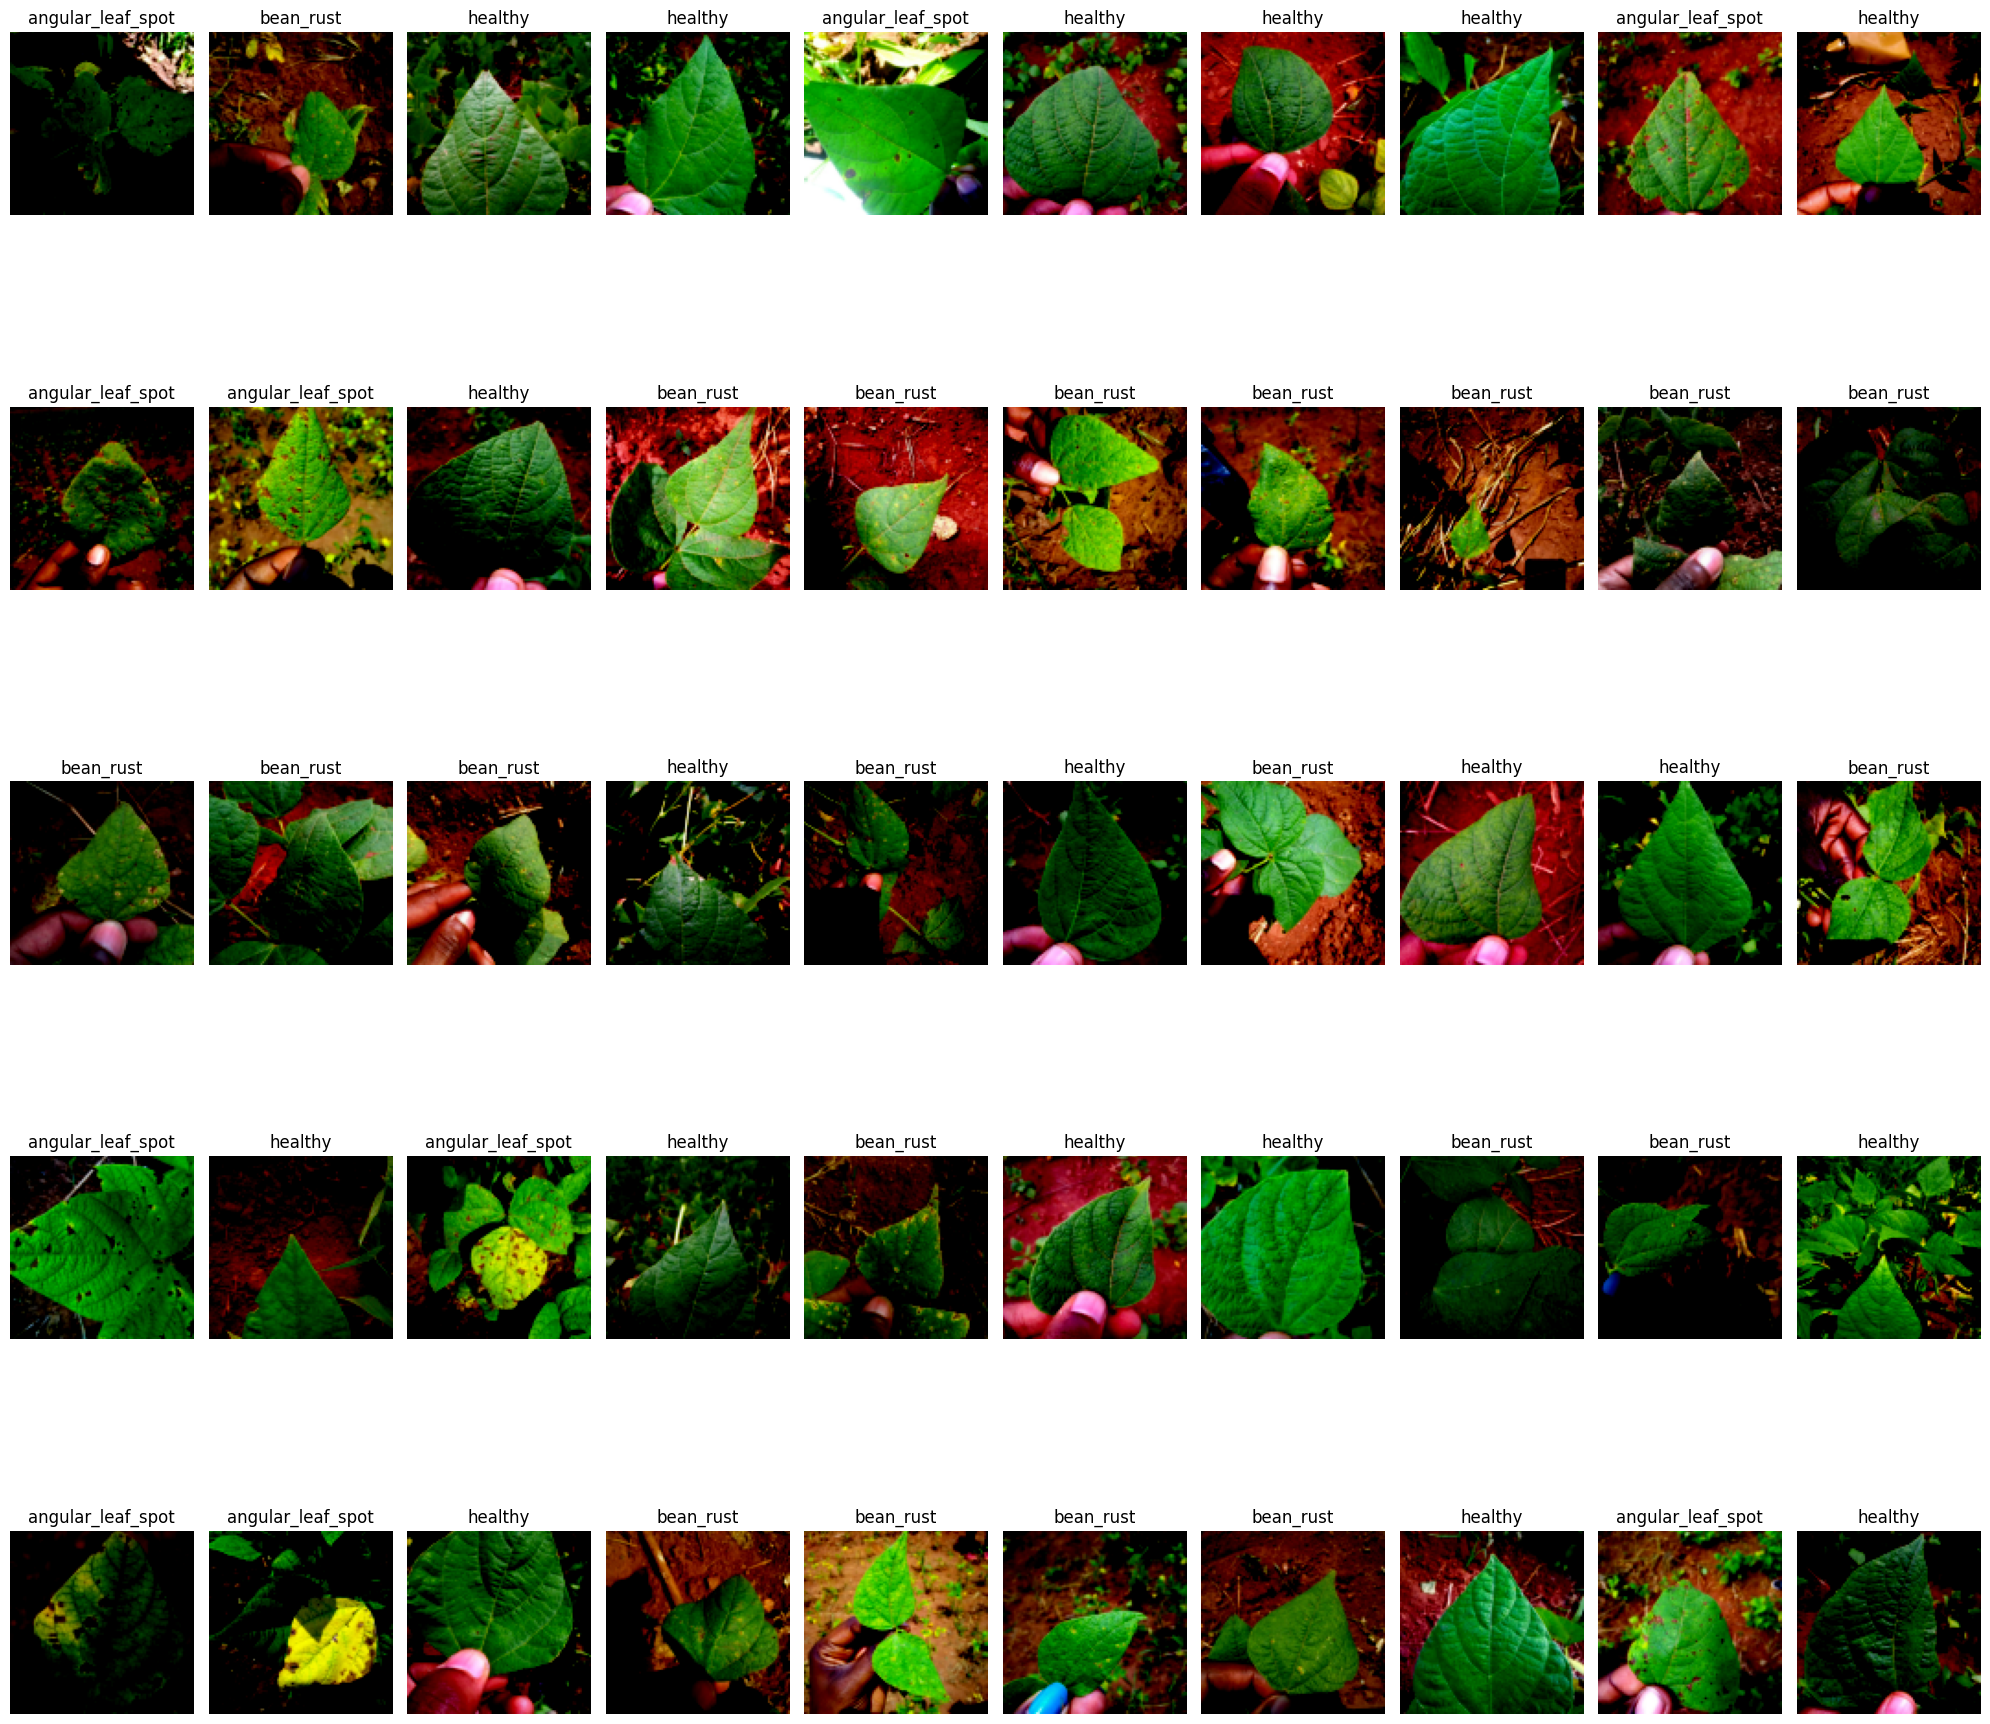

In [ ]:
random_indexes = random.sample(range(len(train_dataset)), 50)

num_images_per_row = 10
num_rows = len(random_indexes) // num_images_per_row

fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(20, 20))

for i, idx in enumerate(random_indexes):
    row = i // num_images_per_row
    col = i % num_images_per_row

    image, label = train_dataset[idx]
    class_name = train_dataset.classes[label]

    image = np.transpose(image, (1, 2, 0))

    axes[row, col].imshow(image)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


# 5) Структура своей нейросети и ее обучение

In [ ]:
class_names = dataset['train'].features['labels'].names

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.linear_1 = nn.Linear(100 * 100 * 3, 256)
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, 16)
        self.linear_4 = nn.Linear(16, len(class_names))
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.relu(self.linear_3(x))
        x = self.linear_4(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
loss_values = []
print("Эпоха:")

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
      
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    loss_values.append(epoch_loss)
    
    print(f'{epoch+1}) Loss-значение: {epoch_loss}, Точность: {accuracy}')


Эпоха:
1) Loss-значение: 0.9332029844705875, Точность: 0.5531914893617021
2) Loss-значение: 0.7811697383339589, Точность: 0.6382978723404256
3) Loss-значение: 0.6894063710020139, Точность: 0.6866537717601547
4) Loss-значение: 0.5669681091721241, Точность: 0.7504835589941973
5) Loss-значение: 0.5040220768405841, Точность: 0.7843326885880078
6) Loss-значение: 0.3970079514950227, Точность: 0.839458413926499
7) Loss-значение: 0.3184228538857916, Точность: 0.867504835589942
8) Loss-значение: 0.30053232471064595, Точность: 0.8936170212765957
9) Loss-значение: 0.2209950338552097, Точность: 0.9197292069632496
10) Loss-значение: 0.1929071586113423, Точность: 0.9274661508704062


# 6) Добавление предобученной модели нейросети resnet50 и дообучение на моем датасете

In [ ]:
pretrained_model = resnet50(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, len(class_names))
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)

num_epochs = 10
pretrained_loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    pretrained_loss_values.append(epoch_loss)
    
    print(f'{epoch+1}) Loss-значение: {epoch_loss}, Точность: {accuracy}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1) Loss-значение: 0.8945361664661995, Точность: 0.6624758220502901
2) Loss-значение: 0.6186967246807539, Точность: 0.7408123791102514
3) Loss-значение: 0.5439201498260865, Точность: 0.7794970986460348
4) Loss-значение: 0.3556280021484082, Точность: 0.867504835589942
5) Loss-значение: 0.42723723790393425, Точность: 0.8433268858800773
6) Loss-значение: 0.34964856842819314, Точность: 0.8752417794970987
7) Loss-значение: 0.31538915797494926, Точность: 0.8897485493230174
8) Loss-значение: 0.24800238457436746, Точность: 0.9090909090909091
9) Loss-значение: 0.25363184889921775, Точность: 0.913926499032882
10) Loss-значение: 0.14396390166635123, Точность: 0.9555125725338491


# 7) Финальные метрики нейросетей

In [ ]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total) * 100

model_accuracy = compute_accuracy(model, test_loader)
pretrained_model_accuracy = compute_accuracy(pretrained_model, test_loader)

print(f'Точность моей нейросети: {model_accuracy}%')
print(f'Точность предобученной нейросети resnet50: {pretrained_model_accuracy}%')


Точность моей нейросети: 70.11494252873564%
Точность предобученной нейросети resnet50: 85.44061302681992%
